In [1]:
import sys
import os
if os.getenv('RBMHOME') != None:
    os.chdir(os.getenv('RBMHOME'))
sys.path.append(os.getcwd() + '/src')
sys.path.append(os.getcwd() + '/src/RBMs')
import importlib
import importlib
import torch
from torch.nn.functional import one_hot
import scoresL
from h5py import File
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
from matplotlib import cm
from tqdm import tqdm
import gzip
from matplotlib.colors import to_hex
import h5py
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec

In [2]:
# use LaTeX fonts in the plots
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({'font.size': 15})
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}'
plt.rcParams['legend.title_fontsize'] = 'xx-small'

In [68]:
# to change
device = torch.device('cuda:0')
# model = 'models/TestFourMasters/Test4MRdm.h5'
# model = 'models/TestFourMasters/BernoulliBernoulliSslRBM-2024.9.26.16.29-TestFourMasters-ep10000-lr0.004-Nh512-NGibbs100-mbs500-partialLabelsFalse-lr_labels0.004-L10.0-L20.0-Rdm.h5'
# model = 'models/TestFourMasters/BernoulliBernoulliSslRBM-2024.9.26.16.27-TestFourMasters-ep10000-lr0.004-Nh512-NGibbs100-mbs500-partialLabelsFalse-lr_labels0.004-L10.0-L20.0-PCD.h5'
model = 'models/TestFourMasters_Binned/BernoulliBernoulliSslRBM-2024.10.7.12.16-TestFourMasters_Binned-ep10000-lr0.004-Nh512-NGibbs20-mbs500-partialLabelsFalse-lr_labels0.004-L10.0-L20.0-Rdm.h5'
data_name = 'PIANO_Binned'
data_set = 'train'
cmap = 'tab10'

folder_name = f'/home/adecelle/work/FeF-main/results/FeF_scores/FeF_scores-{data_name}-Nh512-Rdm100-train'
os.makedirs(folder_name,exist_ok=True)
gen_time = 1000
num_samples = -1
num_points_trajectory = 50
batch_size = 300
replication_factor = 2

In [69]:
# f = h5py.File('data/DNA.h5', 'r')
f = h5py.File('data/TestFourMasters.h5', 'r')
data_type = 'train'

labels = f[data_type + '_labels'].asstr()[()]
print(f'total length: {len(labels)}\n')
lab, counts = np.unique(labels, return_counts=True)
print('label -> count')
for l, c in zip(lab, counts):
    print(f'{l} -> {c}')
f.close()

total length: 9919

label -> count
0 -> 2788
1 -> 2212
2 -> 2788
3 -> 2131


In [70]:
def plot_scatter_labels(ax, proj1, proj2):    
    for lab in unique_labels:
        idx = np.where(lab == labels_data)[0]
        ax.scatter(data_proj[idx, proj1], data_proj[idx, proj2], color=colors_dict[lab], s=50, zorder=0, alpha=0.5)
        idx = np.where(label2num[lab] == targets.cpu().numpy())[0]
        ax.scatter(gen_data_proj[idx, proj1], gen_data_proj[idx, proj2], color=colors_dict[lab], label=lab, s=20, zorder=2, edgecolor='black', marker='o', alpha=1, linewidth=0.4)
    ax.set_xlabel(f'{proj1+1} PC')
    ax.set_ylabel(f'{proj2+1} PC')
    
def plot_hist(ax, proj, orientation='vertical'):    
    ax.hist(data_proj[:, proj], bins=50, color='black', histtype='step', label='data', zorder=1, density=True, orientation=orientation)
    ax.hist(gen_data_proj[:, proj], bins=50, color='#846DCE', label='generated', zorder=0, alpha=0.8, density=True, orientation=orientation)
    ax.set_xlabel(fr'$m_{proj}$')
    ax.set_ylabel('density')
    ax.axis('off')
    
def plot_scatter_(ax, proj1, proj2):    
    lab = 'European'
    ax.scatter(data_proj[:, proj1], data_proj[:, proj2], color=colors_dict[lab], s=50, zorder=0, alpha=0.5)
    ax.scatter(gen_data_proj[:, proj1], gen_data_proj[:, proj2], color=colors_dict[lab], label=lab, s=20, zorder=2, edgecolor='black', marker='o', alpha=1, linewidth=0.4)
    ax.set_xlabel(f'{proj1+1} PC')
    ax.set_ylabel(f'{proj2+1} PC')

In [72]:
# to change
RBM = importlib.import_module('BernoulliBernoulliSslRBM').RBM
device = torch.device('cuda:1')
# fname_model = 'models/DNA/BernoulliBernoulliSslRBM-2023.6.20.12.3-DNA-ep30000-lr0.01-Nh1024-NGibbs100-mbs4507-partialLabelsFalse-lr_labels0.01-L10.0-L20.0-PCD.h5'
# fname_model = 'models/TestthreeMasters/Test3MRdm.h5'
# fname_model = 'models/TestFourMasters/BernoulliBernoulliSslRBM-2024.9.26.16.29-TestFourMasters-ep10000-lr0.004-Nh512-NGibbs100-mbs500-partialLabelsFalse-lr_labels0.004-L10.0-L20.0-Rdm.h5'
fname_model = 'models/TestFourMasters_Binned/BernoulliBernoulliSslRBM-2024.10.7.12.16-TestFourMasters_Binned-ep10000-lr0.004-Nh512-NGibbs20-mbs500-partialLabelsFalse-lr_labels0.004-L10.0-L20.0-Rdm.h5'
# fname_data = 'data/DNA.h5'
# fname_data = 'data/TestFourMasters.h5'
fname_data = 'data/TestFourMasters_Binned.h5'
data_type = 'train'
n_data = 3000 # take only part of the dataset. Large sequences would otherwise fill the GPU's memory

In [87]:
f_data = h5py.File(fname_data, 'r')
f_model = h5py.File(fname_model, 'r')
all_X_data = np.array(f_data[data_type]).astype(np.float32)
all_labels_data = f_data[data_type + '_labels'].asstr()[()]
# all_sublabels_data = f_data[data_type + '_sublabels'].asstr()[()]

X_data = torch.tensor(all_X_data[:n_data], device=device)
labels_data = all_labels_data[:n_data]
# sublabels_data = all_sublabels_data[:n_data]
unique_labels = np.unique(labels_data)
# unique_sublabels = np.unique(sublabels_data)
# leaves_names = f_data[data_type + '_names'].asstr()[:n_data]

label2num = {lab : i for i, lab in enumerate(np.unique(labels_data))}

rbm = RBM(device=device)
alltime = f_model['alltime'][()]
print('All times:\n', alltime)
stamp = input('Select the time stamp: ')
rbm.loadRBM(fname_model, stamp=int(stamp))
stamp = rbm.t_age

All times:
 [    1   102   203   304   405   506   607   708   809   910  1011  1112
  1213  1314  1415  1516  1617  1718  1819  1920  2021  2122  2223  2324
  2425  2526  2627  2728  2829  2930  3031  3132  3233  3334  3435  3536
  3637  3738  3839  3940  4041  4142  4243  4344  4445  4546  4647  4748
  4849  4950  5051  5152  5253  5354  5455  5556  5657  5758  5859  5960
  6061  6162  6263  6364  6465  6566  6667  6768  6869  6970  7071  7172
  7273  7374  7475  7576  7677  7778  7879  7980  8081  8182  8283  8384
  8485  8586  8687  8788  8889  8990  9091  9192  9293  9394  9495  9596
  9697  9798  9899 10000]


In [88]:
_, S_data, V_data = torch.svd(X_data - X_data.mean(0))
#_, S_data, V_data = torch.svd(X_data)
# _, S_data, V_data = torch.svd(rbm.W.T)
# print(S_data)
V_data /= X_data.shape[1]**0.5

data_proj = X_data @ V_data
data_proj = data_proj.cpu().numpy()

In [89]:
main_colors = ['#0094FF', '#009A00', '#C43CC8', '#D03A24', '#A89400'] # Blue, Green, Violet, Red, Yellow
secondary_colors = ['#002CFF', '#0094FF', '#00CEFF', '#58FBDA', '#B0CBD2',                        # 5 blue,
                    '#A005A6', '#C43CC8', '#E861EB', '#FF84FF', '#FFA7FF',                        # 5 violet
                    '#003D00', '#006900', '#009A00', '#00CB00', '#15FF00',                        # 5 green
                    '#A60505', '#D03A24', '#FA5F43', '#FF8463',                                   # 4 red
                    '#382600', '#554900', '#7C6D00', '#A89400', '#D5BC15', '#FFBA4A', '#FFEDCB']  # 7 yellow

all_cont = ['European', 'South Asian', 'East Asian', 'American', 'African']
all_cont = ['0', '1', '2', '3'] # , 'American', 'African']

all_pops =   ['FIN', 'GBR', 'CEU', 'IBS', 'TSI',                  # European
              'CHS', 'CDX', 'CHB', 'JPT', 'KHV',                  # South Asian
              'GIH', 'STU', 'PJL', 'ITU', 'BEB',                  # East Asian
              'PEL', 'MXL', 'CLM', 'PUR',                         # American
              'ACB', 'GWD', 'YRI', 'LWK', 'ESN', 'MSL', 'ASW']    # African


colors_dict = {cont : color for cont, color in zip(all_cont, main_colors)}
print(colors_dict)
#subcolors_dict = {population : color for population, color in zip(all_pops, secondary_colors)}
#labels_dict = {leaf_name : leaf_label for leaf_name, leaf_label in zip(leaves_names, labels_data)}
#sublabels_dict = {leaf_name : leaf_label for leaf_name, leaf_label in zip(leaves_names, sublabels_data)}

{'0': '#0094FF', '1': '#009A00', '2': '#C43CC8', '3': '#D03A24'}


In [90]:
it_mcmc = 20
n_gen = len(X_data)
targets = torch.tensor([label2num[l] for l in labels_data], device=device, dtype=torch.int64)
rand_init = torch.randint(0, 2, size=(len(targets), rbm.Nv), device=device).float()
gen_data, *_ = rbm.conditioned_sampling(rand_init, targets, it_mcmc=it_mcmc)
gen_data_proj = gen_data @ V_data
gen_data_proj = gen_data_proj.cpu().numpy()

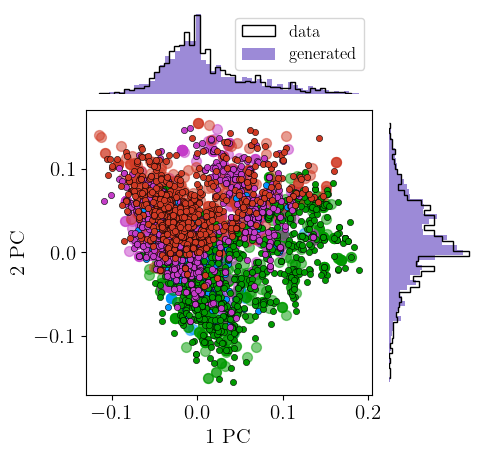

In [91]:
plt.rcParams['legend.title_fontsize'] = 'medium'
fig = plt.figure(dpi=100, figsize=(5,5))
gs = GridSpec(4, 4)

def plot_scatter_labels(ax, proj1, proj2):    
    for lab in unique_labels:
        idx = np.where(lab == labels_data)[0]
        ax.scatter(data_proj[idx, proj1], data_proj[idx, proj2], color=colors_dict[lab], s=50, zorder=0, alpha=0.5)
        idx = np.where(label2num[lab] == targets.cpu().numpy())[0]
        ax.scatter(gen_data_proj[idx, proj1], gen_data_proj[idx, proj2], color=colors_dict[lab], label=lab, s=20, zorder=2, edgecolor='black', marker='o', alpha=1, linewidth=0.4)
    ax.set_xlabel(f'{proj1+1} PC')
    ax.set_ylabel(f'{proj2+1} PC')
    
ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_x = fig.add_subplot(gs[0,0:3])
ax_hist_y = fig.add_subplot(gs[1:4, 3])

plot_scatter_labels(ax_scatter, 0, 1)

plot_hist(ax_hist_x, 0)
plot_hist(ax_hist_y, 1, orientation='horizontal')

ax_hist_x.legend(fontsize=12, bbox_to_anchor=(1, 1));
h, l = ax_scatter.get_legend_handles_labels()
# lgnd = fig.legend(h, l, ncol=2, bbox_to_anchor=(0.8,0.5), fontsize=15, title='HGD - Human genome')
#for handle in lgnd.legendHandles:
#    handle._sizes = [50]
#fig.gca().add_artist(lgnd)
# plt.savefig('/home/lorenzo.rosset/Documents/drawings/FeF/svg/PCA_hist-HGD-PCD.svg')

In [92]:
def plot_scatter_c(ax, data_proj, gen_data_proj, proj1, proj2, lab,show_lab=True):    
    # lab = 'European'
    ax.scatter(data_proj[:, proj1], data_proj[:, proj2], color=colors_dict[lab], s=50, zorder=0, alpha=0.5)
    ax.scatter(gen_data_proj[:, proj1], gen_data_proj[:, proj2], color=colors_dict[lab], label=lab, s=20, zorder=2, edgecolor='black', marker='o', alpha=1, linewidth=0.4)
    if show_lab:
        ax.set_xlabel(f'{proj1+1} PC')
        ax.set_ylabel(f'{proj2+1} PC')

def plot_hist_c(ax, proj, data_proj, gen_data_proj, orientation='vertical'):    
    ax.hist(data_proj[:, proj], bins=50, color='black', histtype='step', label='data', zorder=1, density=True, orientation=orientation)
    ax.hist(gen_data_proj[:, proj], bins=50, color='#846DCE', label='generated', zorder=0, alpha=0.8, density=True, orientation=orientation)
    ax.set_xlabel(fr'$m_{proj}$')
    ax.set_ylabel('density')
    ax.axis('off')

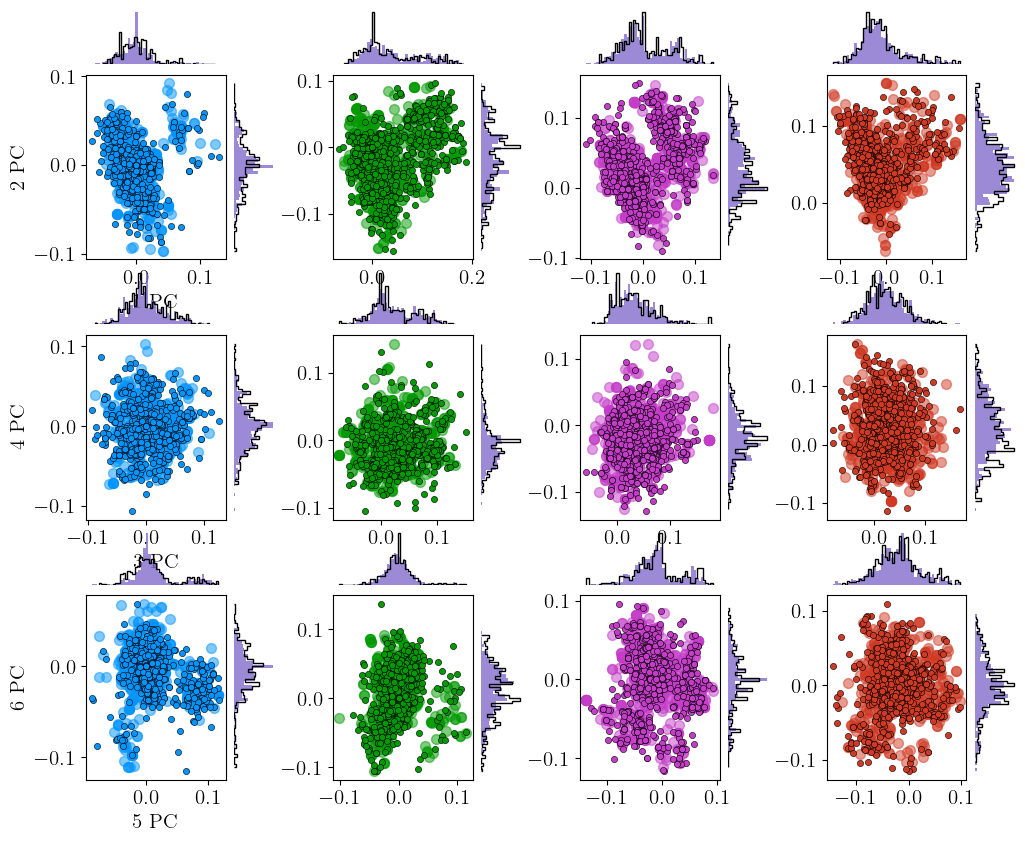

In [93]:
Xsc_cat = []
Gsc_cat = []
for lab in unique_labels:
    idx_l = np.where(labels_data==lab)[0]
    Xsc_cat.append(data_proj[idx_l,:])
    
    idx_l = np.where(label2num[lab] == targets.cpu().numpy())[0]
    Gsc_cat.append(gen_data_proj[idx_l,:])

plt.rcParams['legend.title_fontsize'] = 'medium'
fig = plt.figure(dpi=100, figsize=(12,10))
gs = GridSpec(12, 19)

for n_v in range(3):
    for idx_lab in range(4):
        # idx_lab = 0
        p1 = 2*n_v
        p2 = 2*n_v+1
        show_lab = True
        if idx_lab>0:
            show_lab = False
            
        ax_scatter = fig.add_subplot(gs[(n_v*4+1):(n_v*4+4), (idx_lab*5):(idx_lab*5+3)])
        ax_hist_x = fig.add_subplot(gs[n_v*4,(idx_lab*5):(idx_lab*5+3)])
        ax_hist_y = fig.add_subplot(gs[(n_v*4+1):(n_v*4+4), (idx_lab*5+3)])

        #ax_scatter = fig.add_subplot(gs[1:4, (idx_lab*5):(idx_lab*5+3)])
        #ax_hist_x = fig.add_subplot(gs[0,(idx_lab*5):(idx_lab*5+3)])
        #ax_hist_y = fig.add_subplot(gs[1:4, (idx_lab*5+3)])

        plot_scatter_c(ax_scatter, Xsc_cat[idx_lab], Gsc_cat[idx_lab], p1, p2, unique_labels[idx_lab],show_lab)
        plot_hist_c(ax_hist_x, p1, Xsc_cat[idx_lab], Gsc_cat[idx_lab])
        plot_hist_c(ax_hist_y, p2, Xsc_cat[idx_lab], Gsc_cat[idx_lab], orientation='horizontal')


